In [1]:
using Revise

using SSMCMain, SSMCMain.ModifiedMiCRM.RandomSystems

using LinearAlgebra
using Random
using Distributions
using Base.Threads
using Logging

using HypothesisTests
using DimensionalData
using JLD2

In [2]:
using CairoMakie
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

# System 1 (a particular choice for all params except Ds)

In [12]:
function make_rsg1(Ds, Dr;
    N=10,
    lm=0.2,
    lc=1.,
    ll=1.,
    lsi=0.1,
    lsr=0.5,
    lsb=0.2,
)
    total_influx = 1.0 * N # setting E (or E/V)
    Kmean = total_influx / (lsi * N)
    K = (Kmean, Kmean * sigma_to_mu_ratio1())
    
    rsg = RSGJans1(N, N;
        m=(lm, lm * sigma_to_mu_ratio1()),
        r=1.0, # setting T
        sparsity_influx=lsi,
        K,
        sparsity_resources=lsr,
        sparsity_byproducts=lsb,
        c=(lc, lc * sigma_to_mu_ratio1()),
        l=(ll, ll * sigma_to_mu_ratio1()),
        Ds, Dr # diffusions passed through
    )
end
function sigma_to_mu_ratio1()
    (2 / 3) / 2.355
end

sigma_to_mu_ratio1 (generic function with 1 method)

## Keeping all Ds the same but changing the value

In [13]:
function run1(Ds, Dr, num_runs=200)
    rsg = make_rsg1(Ds, Dr);
    rcodes = example_do_rg_run2(rsg, num_runs, 100, 1000;
        maxresidthr=1e-8,
        tol=1e-11,
        timelimit=10
    )
    
    cm = countmap(rcodes)
    good_count = get(cm, 101, 0) + get(cm, 1, 0) + get(cm, 2, 0)
    good_ratio = good_count / sum(values(cm))
    if good_ratio < 0.95
        @warn (@sprintf "Getting lots of bad runs, good_raio is %g" good_ratio)
    end
    
    instability_stats(cm)
end

run1 (generic function with 2 methods)

In [87]:
Dr = 1.
Dss = 10. .^ (-2:-2:-16)
num_runs = length(Dss)
vals = Float64[]
cis = Tuple{Float64,Float64}[]
mins = Float64[]
maxs = Float64[]
disable_logging(Warn)
for (i, Ds) in enumerate(Dss)
    rslt = run1(Ds, Dr, 500)
    push!(vals, rslt[1])
    push!(mins, rslt[2][1])
    push!(maxs, rslt[2][2])
    push!(cis, rslt[2])
    @printf "Finished %d out of %d \n" i num_runs
    flush(stdout)
end
disable_logging(Debug)

Finished 1 out of 8 
Finished 2 out of 8 
Finished 3 out of 8 
Finished 4 out of 8 
Finished 5 out of 8 
Finished 6 out of 8 
Finished 7 out of 8 
Finished 8 out of 8 


LogLevel(-999)

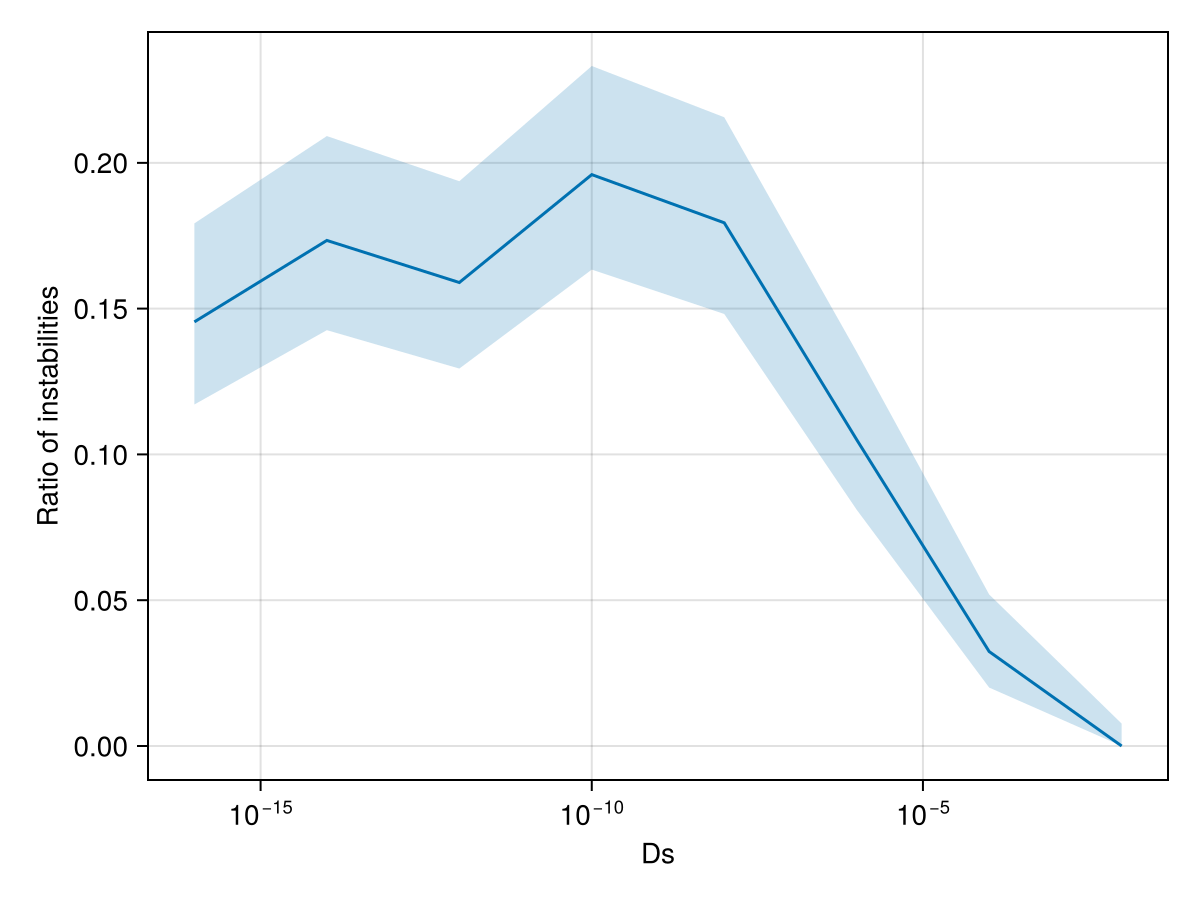

In [88]:
fap = lines(Dss, vals; axis=(; xscale=log10))
band!(fap.axis, Dss, mins, maxs; alpha=0.5)
fap.axis.xlabel = "Ds"
fap.axis.ylabel = "Ratio of instabilities"
fap

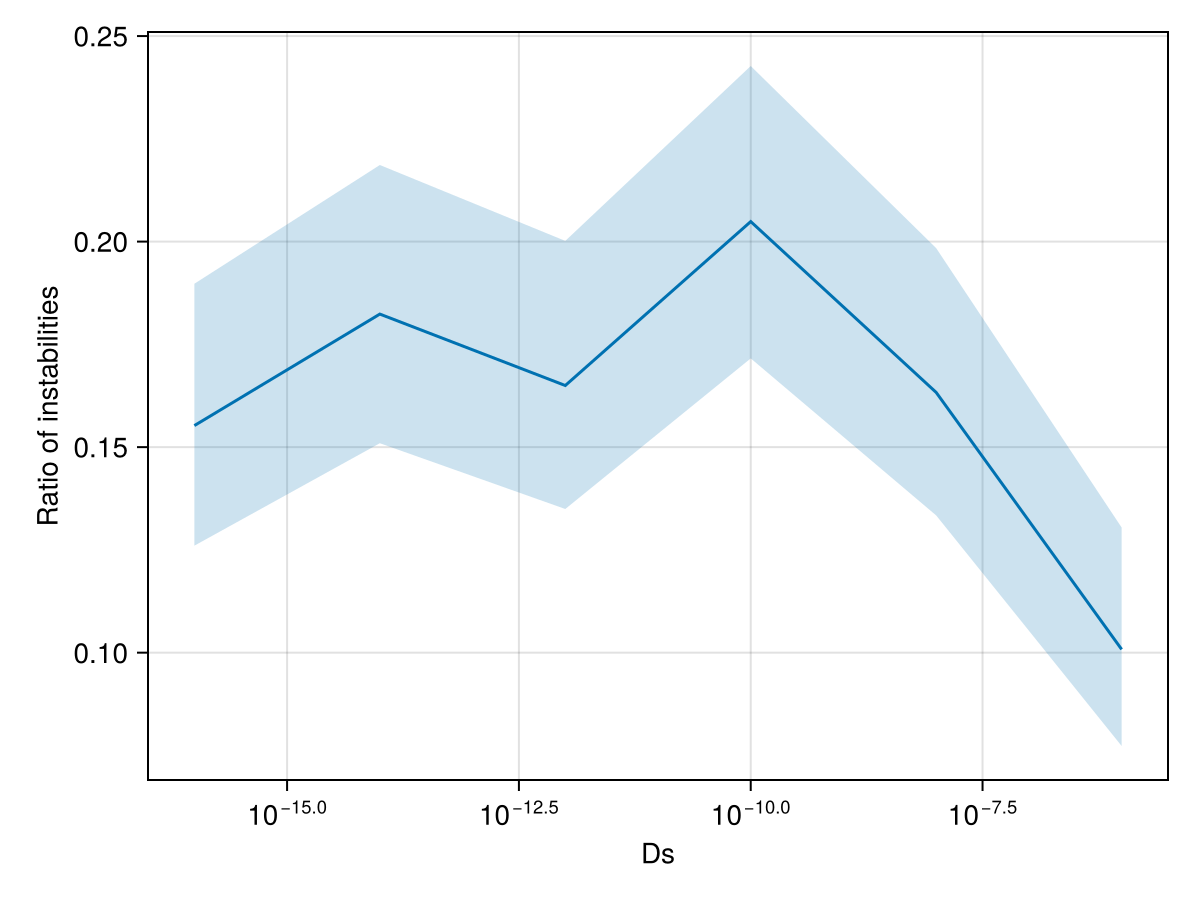

In [9]:
fap = lines(Dss, vals; axis=(; xscale=log10))
band!(fap.axis, Dss, mins, maxs; alpha=0.5)
fap.axis.xlabel = "Ds"
fap.axis.ylabel = "Ratio of instabilities"
fap

## Having Ds fixed and Dr mean 1 but changing its variance

In [44]:
function run2(Drstd=0., Ds=1e-10, Dr=1., num_runs=200)
    rsg = make_rsg1(Ds, (Dr, Drstd));
    rcodes = example_do_rg_run2(rsg, num_runs, 100, 1000;
        maxresidthr=1e-8,
        tol=1e-11,
        timelimit=10
    )
    
    cm = countmap(rcodes)
    good_count = get(cm, 101, 0) + get(cm, 1, 0) + get(cm, 2, 0)
    good_ratio = good_count / sum(values(cm))
    if good_ratio < 0.95
        @warn (@sprintf "Getting lots of bad runs, good_raio is %g" good_ratio)
    end
    
    instability_stats(cm)
end

run2 (generic function with 5 methods)

In [41]:
Ds = 1e-10
Dr = 1.

Drstds = [0., 1e-5, 1e-2, 0.1, 0.5, 1., 2., 5.]

num_runs = length(Drstds)

vals = Float64[]
cis = Tuple{Float64,Float64}[]
mins = Float64[]
maxs = Float64[]

disable_logging(Warn)
for (i, Drstd) in enumerate(Drstds)
    rslt = run2(Drstd, Ds, Dr, 500)
    push!(vals, rslt[1])
    push!(mins, rslt[2][1])
    push!(maxs, rslt[2][2])
    push!(cis, rslt[2])
    @printf "Finished %d out of %d \n" i num_runs
    flush(stdout)
end
disable_logging(Debug);

Finished 1 out of 8 
Finished 2 out of 8 
Finished 3 out of 8 
Finished 4 out of 8 
Finished 5 out of 8 
Finished 6 out of 8 
Finished 7 out of 8 
Finished 8 out of 8 


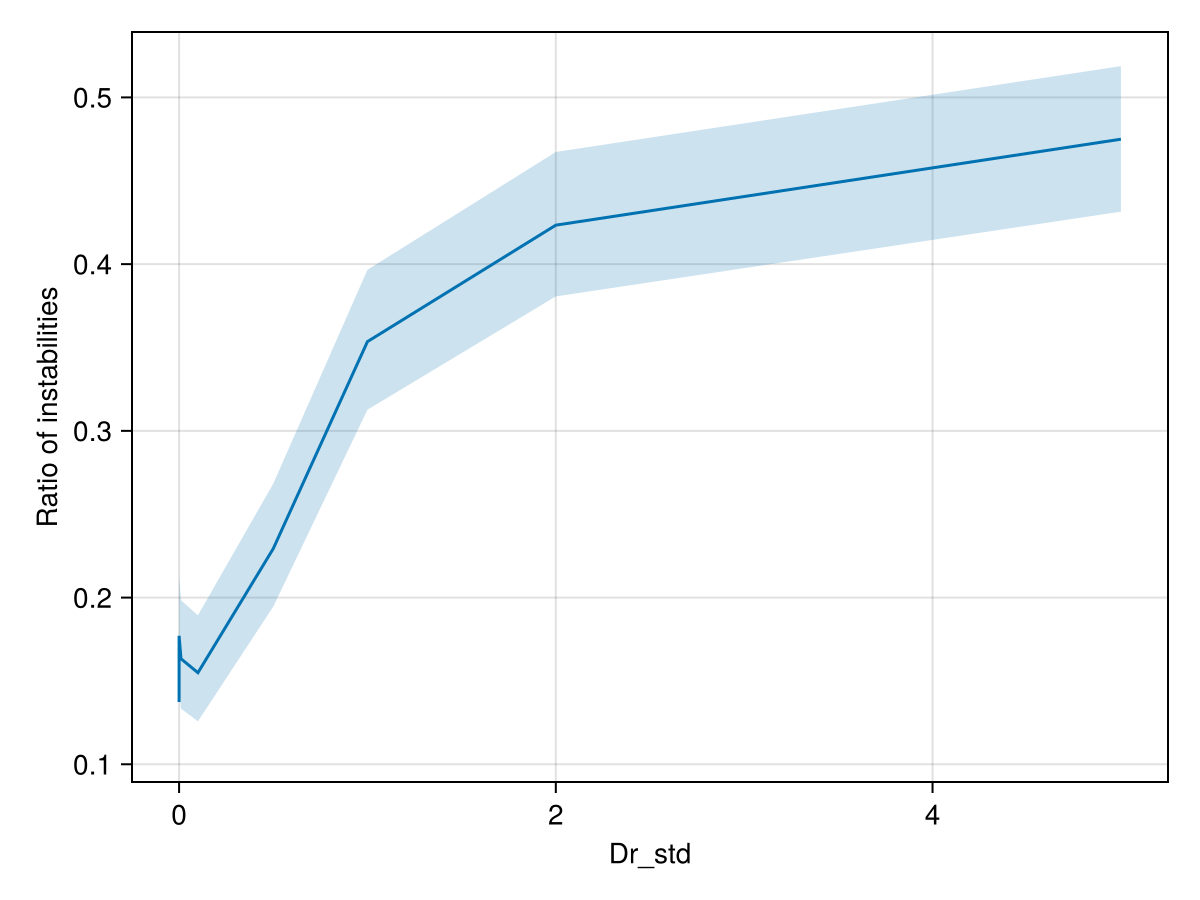

In [42]:
fap = lines(Drstds, vals)
band!(fap.axis, Drstds, mins, maxs; alpha=0.5)
fap.axis.xlabel = "Dr_std"
fap.axis.ylabel = "Ratio of instabilities"
fap

## Moving to log normal for Dr, keeping Ds fixed

In [45]:
function run3(Drlstd=0., Ds=1e-10, Drlm=0., num_runs=200)
    rsg = make_rsg1(Ds, LogNormal(Drlm, Drlstd));
    rcodes = example_do_rg_run2(rsg, num_runs, 100, 1000;
        maxresidthr=1e-8,
        tol=1e-11,
        timelimit=10
    )
    
    cm = countmap(rcodes)
    good_count = get(cm, 101, 0) + get(cm, 1, 0) + get(cm, 2, 0)
    good_ratio = good_count / sum(values(cm))
    if good_ratio < 0.95
        @warn (@sprintf "Getting lots of bad runs, good_raio is %g" good_ratio)
    end
    
    instability_stats(cm)
end

run3 (generic function with 5 methods)

In [97]:
Ds = 1e-10
Dr = 1.

Drlstds = [1e-10, 0.0001, 0.001, 0.01, 0.1]

num_runs = length(Drlstds)

vals = Float64[]
cis = Tuple{Float64,Float64}[]
mins = Float64[]
maxs = Float64[]

disable_logging(Warn)
for (i, Drlstd) in enumerate(Drlstds)
    @time rslt = run3(Drlstd, Ds, Dr, 1000)
    push!(vals, rslt[1])
    push!(mins, rslt[2][1])
    push!(maxs, rslt[2][2])
    push!(cis, rslt[2])
    @printf "Finished %d out of %d \n" i num_runs
    flush(stdout)
end
disable_logging(Debug);

107.099285 seconds (94.62 M allocations: 37.632 GiB, 6.90% gc time)
Finished 1 out of 5 
106.918839 seconds (94.66 M allocations: 37.584 GiB, 2.50% gc time)
Finished 2 out of 5 
103.230142 seconds (93.83 M allocations: 37.260 GiB, 3.54% gc time)
Finished 3 out of 5 
109.463721 seconds (92.12 M allocations: 36.733 GiB, 2.41% gc time)
Finished 4 out of 5 
115.231010 seconds (95.34 M allocations: 37.708 GiB, 3.18% gc time)
Finished 5 out of 5 


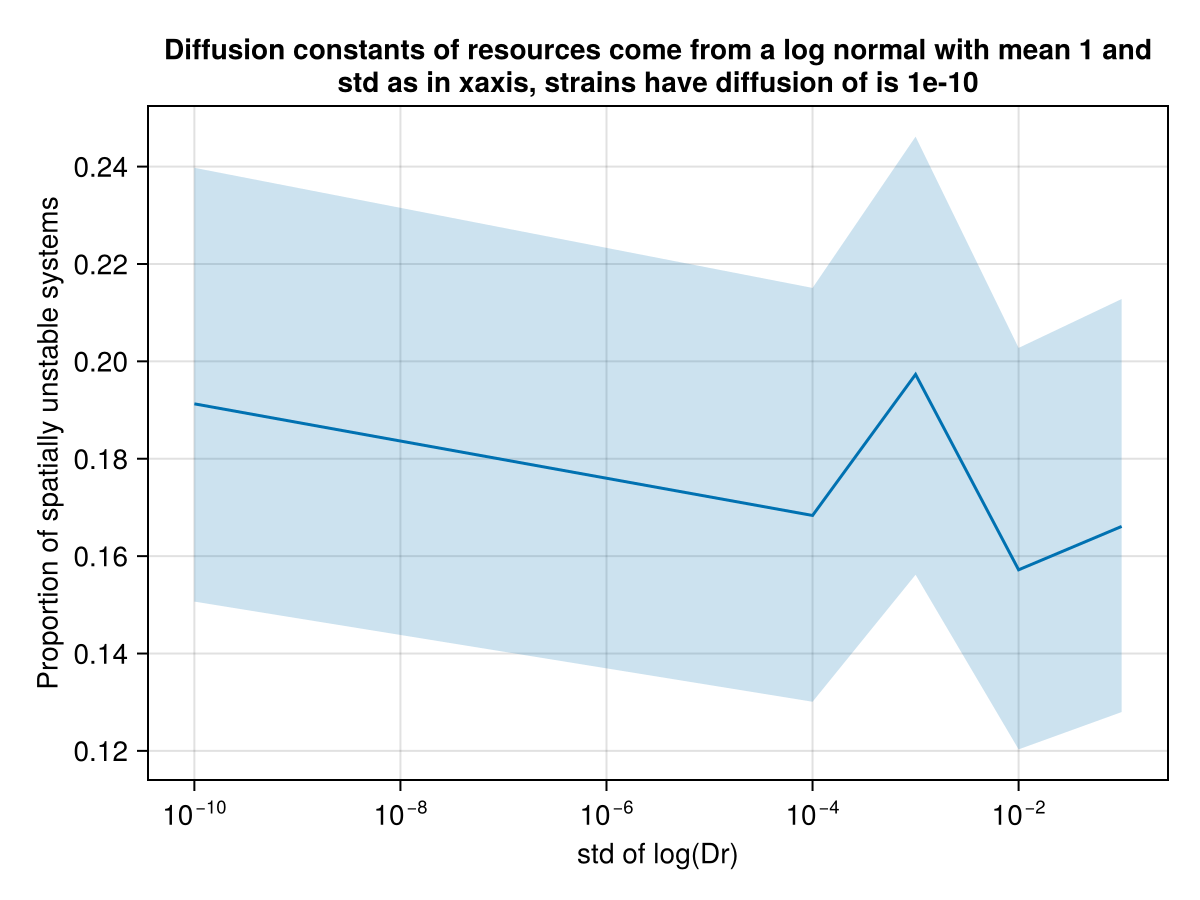

In [96]:
fap = lines(Drlstds, vals; axis=(; xscale=log10))
band!(fap.axis, Drlstds, mins, maxs; alpha=0.5)
fap.axis.title = @sprintf "Diffusion constants of resources come from a log normal with mean %.1g and\nstd as in xaxis, strains have diffusion of is %.3g" Dr Ds
fap.axis.xlabel = "std of log(Dr)"
fap.axis.ylabel = "Proportion of spatially unstable systems"
fap

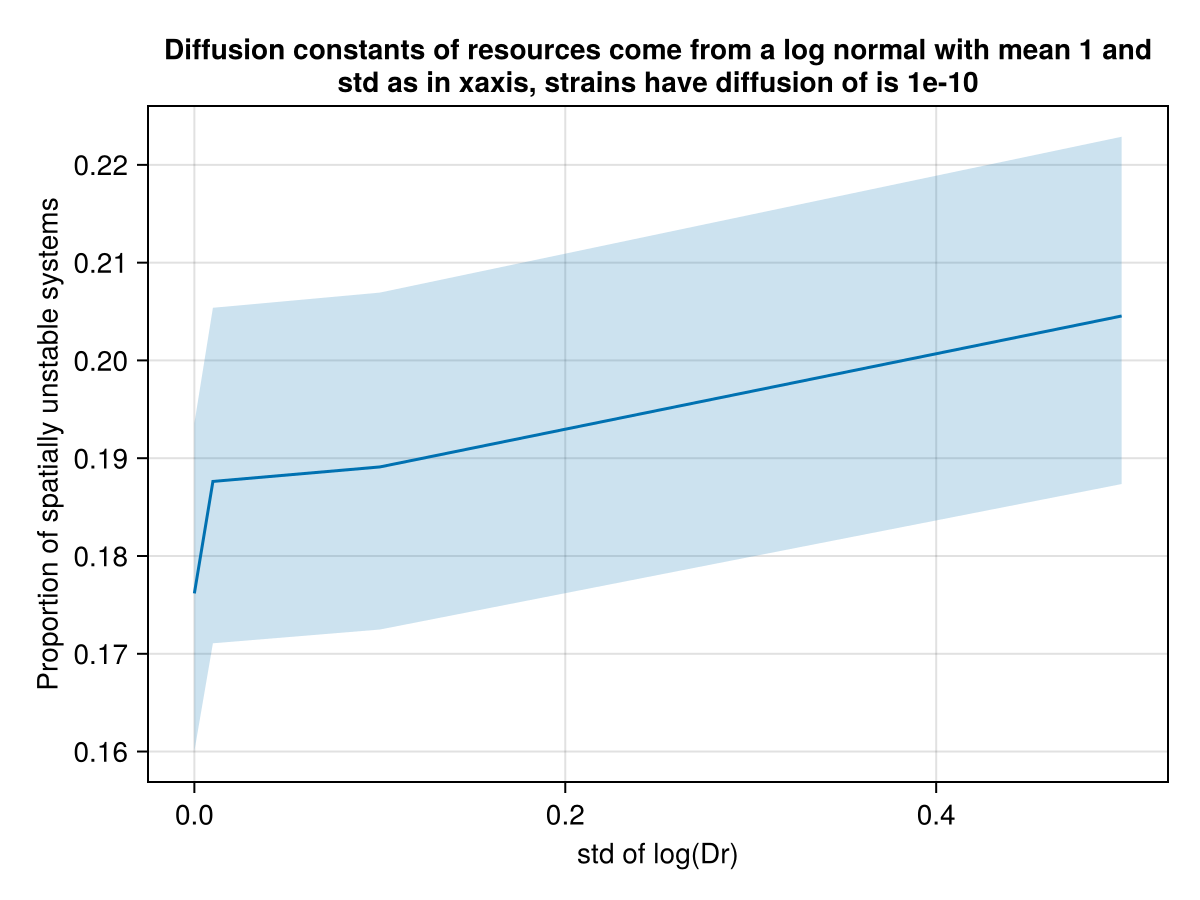

In [86]:
fap = lines(Drlstds, vals; axis=(; xscale=identity))
band!(fap.axis, Drlstds, mins, maxs; alpha=0.5)
fap.axis.title = @sprintf "Diffusion constants of resources come from a log normal with mean %.1g and\nstd as in xaxis, strains have diffusion of is %.3g" Dr Ds
fap.axis.xlabel = "std of log(Dr)"
fap.axis.ylabel = "Proportion of spatially unstable systems"
fap

# Visualizing binomial confints for given N

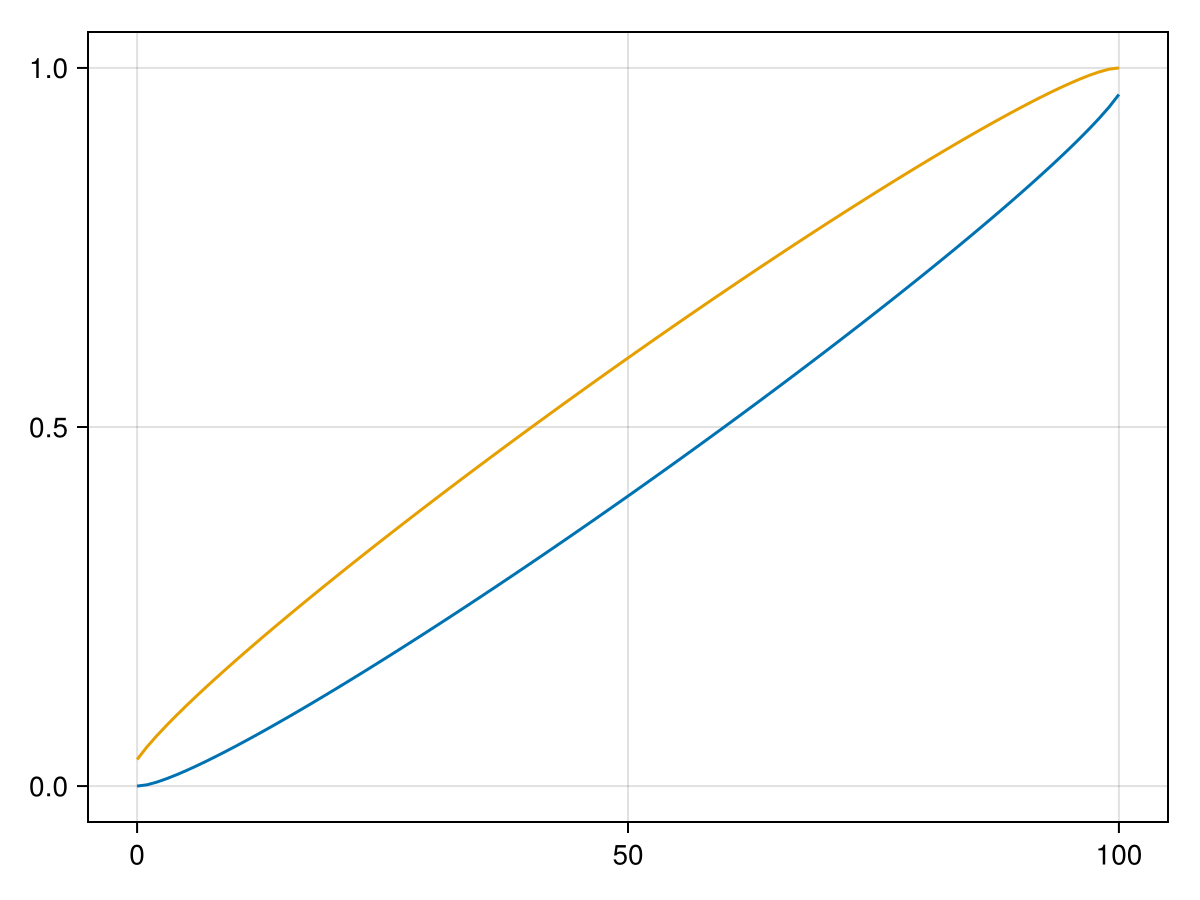

In [40]:
N = 100
xs = 0:N
mins = []
maxs = []
for x in xs
    ci = confint(BinomialTest(x, N); method=:wilson)
    push!(mins, ci[1])
    push!(maxs, ci[2])
end
fap = lines(xs, mins)
lines!(fap.axis, xs, maxs)
fap

# Understanding LogNormal

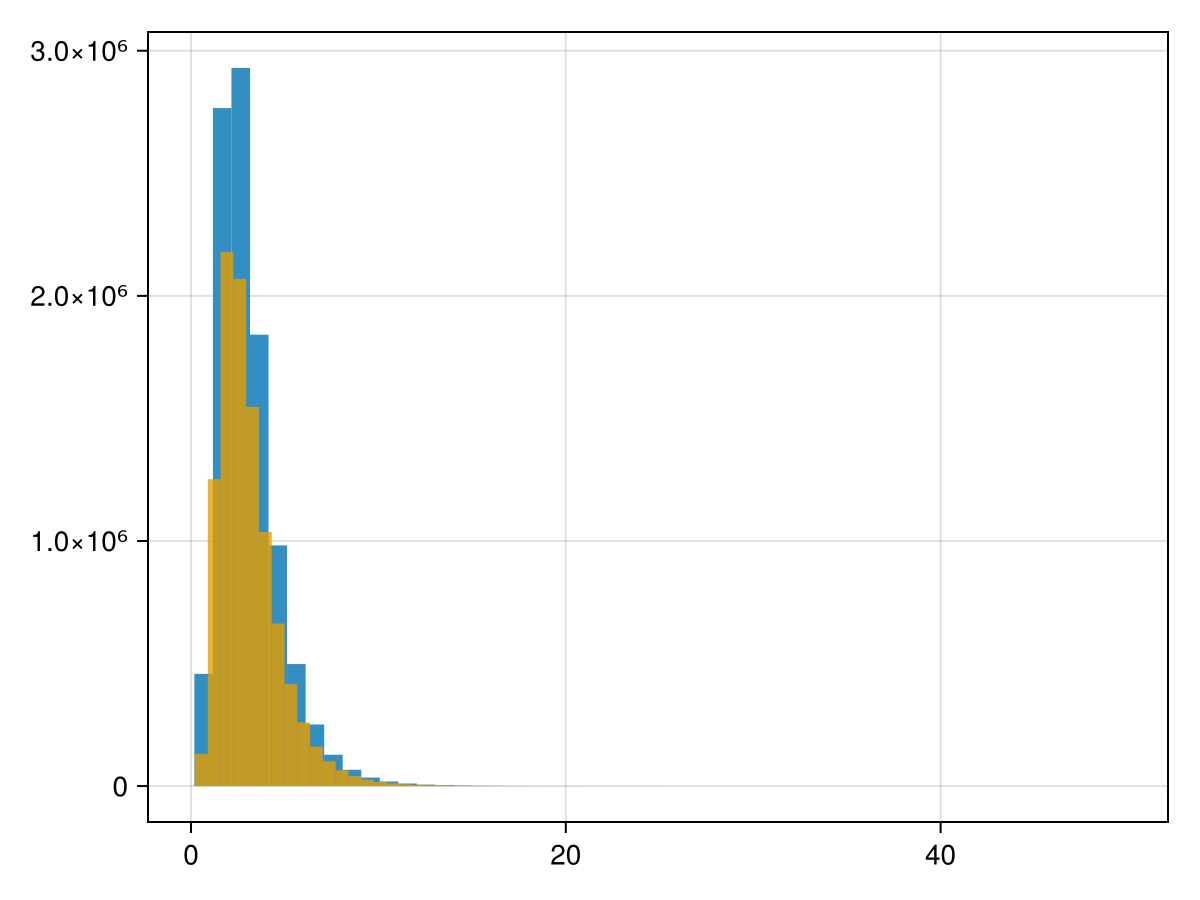

In [149]:
N = 10000000

lns = []
for _ in 1:N
    push!(lns, rand(LogNormal(1., 0.5)))
end
pps = []
for _ in 1:N
    push!(pps, exp(rand(Normal(1., 0.5))))
end

bins = 50
fap = hist(lns; bins)
hist!(fap.axis, pps; bins)
fap

# Extras

In [189]:
GC.gc()
empty!(Out)
GC.gc()